**inports**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.cluster import KMeans
!pip install hdbscan
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from itertools import product



Defaulting to user installation because normal site-packages is not writeable


**Data Generation and Preprocessing**

In [5]:
np.random.seed(20)

circles_data, _ = make_circles(n_samples=500, factor=0.3, noise=0.07, random_state=20)
moons_data, _ = make_moons(n_samples=500, noise=0.05, random_state=20)
blobs_data, _ = make_blobs(n_samples=500, centers=[(-6, 2), (-1, 5), (5, -4)],
                           cluster_std=[0.5, 1.5, 2.0], random_state=20)



**Visualization of Datasets**

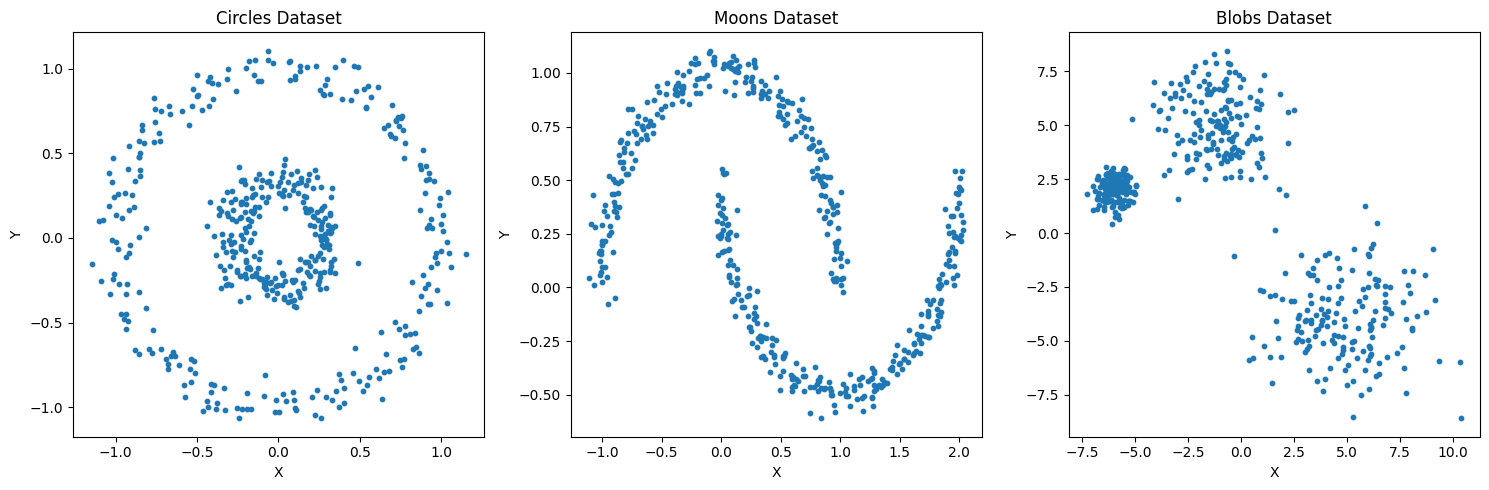

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(circles_data[:, 0], circles_data[:, 1], s=10)
axs[0].set_title("Circles Dataset")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")

axs[1].scatter(moons_data[:, 0], moons_data[:, 1], s=10)
axs[1].set_title("Moons Dataset")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")

axs[2].scatter(blobs_data[:, 0], blobs_data[:, 1], s=10)
axs[2].set_title("Blobs Dataset")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")


plt.tight_layout()
plt.show()

**Affinity Propagation Algorithm Implementation from scratch**

In [10]:
def affinity_propagation(data, max_iter=100, damping=0.5, convergence_iter=10, preference=-150):
    n_samples = data.shape[0]

    # Standardize data
    data = StandardScaler().fit_transform(data)

    # Initialize similarity matrix
    similarity = -np.square(np.linalg.norm(data[:, np.newaxis] - data, axis=2))

    # Set preference(matrix_name , new_preference)
    np.fill_diagonal(similarity, preference)

    # Initialize responsibility and availability
    responsibility = np.zeros((n_samples, n_samples))
    availability = np.zeros((n_samples, n_samples))

    for iteration in range(max_iter):
        #copy to check arrived to Convergence
        old_responsibility = responsibility.copy()
        old_availability = availability.copy()

        # Update responsibility
        tmp = similarity + availability
        max_1 = np.max(tmp, axis=1)
        # second max
        max_2 = np.max(tmp - np.eye(n_samples) * max_1[:, None], axis=1)
        #remove max1 => to remove the role of the sample itself.
        responsibility = similarity - max_1[:, None]
        # add max2 
        responsibility += np.eye(n_samples) * max_2[:, None]
        #add damping
        responsibility = damping * old_responsibility + (1 - damping) * responsibility

        ## Update availability
        # transfer negetive to 0     maximum(arrey1,arrey2)
        positive_responsibility = np.maximum(0, responsibility)
        #save responsibility each sample for itselfe
        np.fill_diagonal(positive_responsibility, responsibility.diagonal())

        availability = np.minimum(0, responsibility.diagonal()[:, None] +
                                   np.sum(positive_responsibility, axis=0) - positive_responsibility)
        availability = damping * old_availability + (1 - damping) * availability

        #save exemplars that have positive (responsibility + availability)
        exemplars = np.where(np.diagonal(responsibility + availability) > 0)[0]
        # check for Convergence(همگرایی) and stop algoritem
        if iteration >= convergence_iter:
            #     ckeck for arrey similarity
            if np.array_equal(exemplars, np.where(np.diagonal(old_responsibility + old_availability) > 0)[0]):
                break

    labels = np.argmax(responsibility + availability, axis=1)
    n_clusters = len(np.unique(labels))
    print(f"Number of clusters: {n_clusters}")

    return labels


**test algoritem**

In [14]:
labels = affinity_propagation(circles_data)
labels = affinity_propagation(moons_data)
labels = affinity_propagation(blobs_data)


Number of clusters: 3
Number of clusters: 6
Number of clusters: 2


**Evaluation Metrics for Clustering**

In [19]:
def grid_search_affinity_propagation(datasets, preference, damping_values, max_iter_values, convergence_iter_values):
    best_results = {}

    for dataset_name, dataset in datasets.items():
        print(f"Grid Search for {dataset_name} dataset...")

        best_score = -np.inf
        best_params = None

        for preference_value, damping, max_iter, convergence_iter in product(preference, damping_values, max_iter_values, convergence_iter_values):
            print(f"Testing with preference={preference_value}, damping={damping}, max_iter={max_iter}, convergence_iter={convergence_iter}")

            AP_out = affinity_propagation(dataset, max_iter=max_iter, damping=damping, convergence_iter=convergence_iter, preference=preference_value)
            n_clusters = len(np.unique(AP_out))

            if n_clusters > 1:
                score = silhouette_score(dataset, AP_out)

                if score > best_score:
                    best_score = score
                    best_params = {
                        'preference': preference_value,
                        'damping': damping,
                        'max_iter': max_iter,
                        'convergence_iter': convergence_iter
                    }

        best_results[dataset_name] = {
            'best_params': best_params,
            'best_score': best_score
        }

        print(f"Best parameters for {dataset_name}: {best_params}")
        print(f"Best Silhouette score for {dataset_name}: {best_score}")
        print("="*50)

    print("Final Best Results for All Datasets:")
    for dataset_name, result in best_results.items():
        print(f"{dataset_name}: Best parameters: {result['best_params']}, Best Silhouette score: {result['best_score']}")

    return best_results


preference = [-200, -150, -100, -50]
damping_values = [0.5, 0.6, 0.7, 0.8]
max_iter_values = [100, 200, 300]
convergence_iter_values = [10, 15, 20]

datasets = {
    'circles': circles_data,
    'moons': moons_data,
    'blobs': blobs_data
}

results = grid_search_affinity_propagation(datasets, preference, damping_values, max_iter_values, convergence_iter_values)


Grid Search for circles dataset...
Testing with preference=-200, damping=0.5, max_iter=100, convergence_iter=10
Number of clusters: 4
Testing with preference=-200, damping=0.5, max_iter=100, convergence_iter=15
Number of clusters: 56
Testing with preference=-200, damping=0.5, max_iter=100, convergence_iter=20
Number of clusters: 72
Testing with preference=-200, damping=0.5, max_iter=200, convergence_iter=10
Number of clusters: 4
Testing with preference=-200, damping=0.5, max_iter=200, convergence_iter=15
Number of clusters: 56
Testing with preference=-200, damping=0.5, max_iter=200, convergence_iter=20
Number of clusters: 72
Testing with preference=-200, damping=0.5, max_iter=300, convergence_iter=10
Number of clusters: 4
Testing with preference=-200, damping=0.5, max_iter=300, convergence_iter=15
Number of clusters: 56
Testing with preference=-200, damping=0.5, max_iter=300, convergence_iter=20
Number of clusters: 72
Testing with preference=-200, damping=0.6, max_iter=100, convergence

**Visualization of Data**

/tmp/ipykernel_16075/2136891466.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20')


Number of clusters: 3


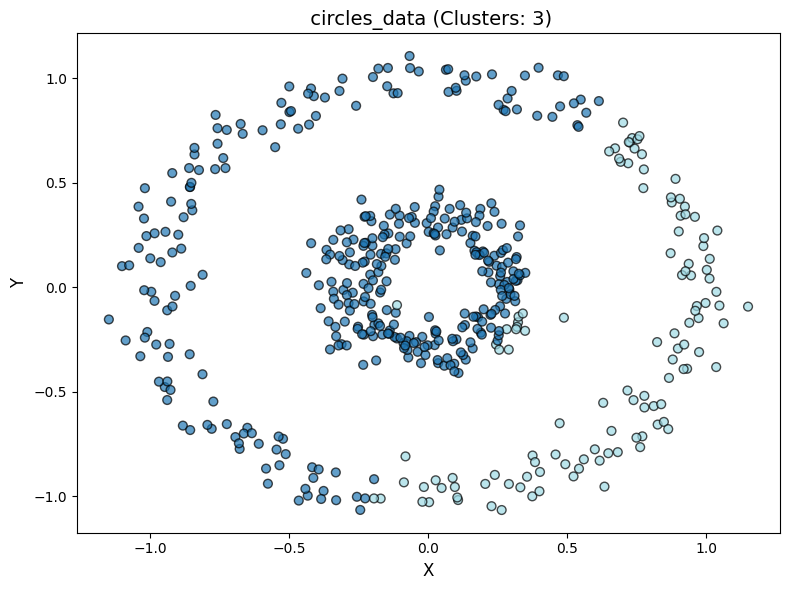

Number of clusters: 6


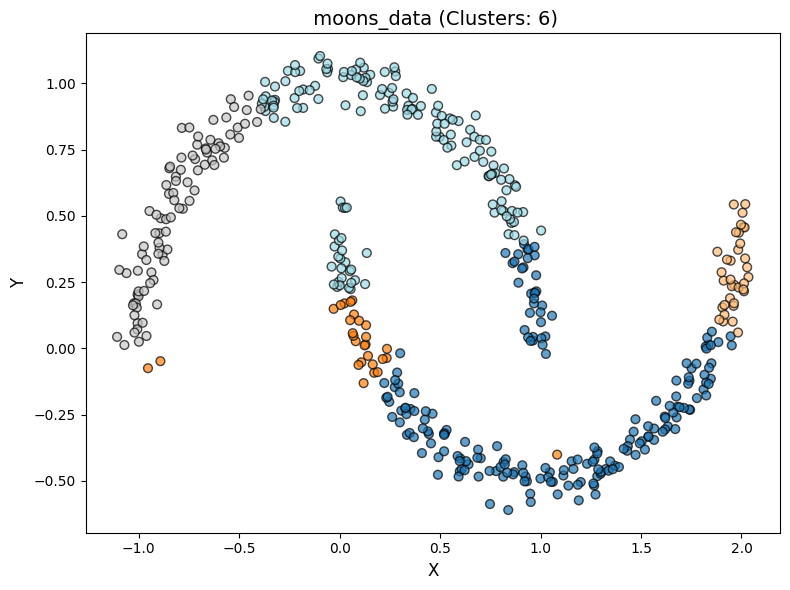

Number of clusters: 2


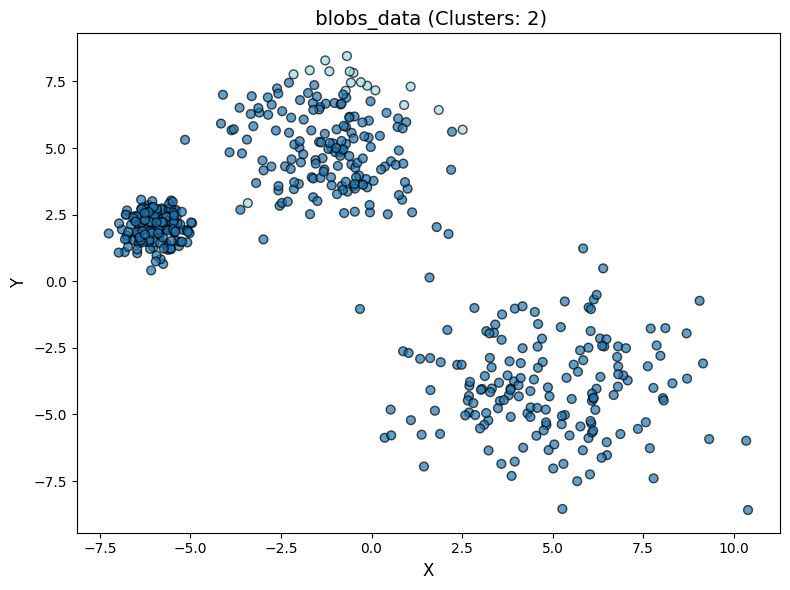

In [7]:
datasets = [circles_data, moons_data, blobs_data]
titles = ["circles_data", "moons_data", "blobs_data"]

colormap = plt.cm.get_cmap('tab20')

for i, data in enumerate(datasets):
    AP_out = affinity_propagation(data)
    n_clusters = len(np.unique(AP_out))

    plt.figure(figsize=(8, 6))
                        #(first col:X, second col:y ,color)
    scatter = plt.scatter(data[:, 0], data[:, 1], c=AP_out, cmap=colormap, s=40, edgecolors='k', alpha=0.7)

    plt.title(f" {titles[i]} (Clusters: {n_clusters})", fontsize=14)
    plt.xlabel("X", fontsize=12)
    plt.ylabel("Y", fontsize=12)

    #adjust distances
    plt.tight_layout()
    plt.show()


**Clustering with K-means Algorithm**

In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define a function to evaluate and compare clustering methods
def evaluate_clustering(data, labels, method_name):
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)
    print(f"{method_name} - Silhouette: {silhouette:.3f}, Calinski-Harabasz: {calinski:.3f}, Davies-Bouldin: {davies:.3f}")

for i, data in enumerate(datasets):
    print(f"\n{titles[i]}:")

    # Apply K-means
    kmeans = KMeans(n_clusters=3, random_state=20)
    kmeans_labels = kmeans.fit_predict(data)
    evaluate_clustering(data, kmeans_labels, "K-means")

    # Apply HDBSCAN
    hdbscan = HDBSCAN(min_cluster_size=10)
    hdbscan_labels = hdbscan.fit_predict(data)
    evaluate_clustering(data, hdbscan_labels, "HDBSCAN")

    # Apply AP
    ap_labels = affinity_propagation(data)  
    evaluate_clustering(data, ap_labels, "AP")




circles_data:
K-means - Silhouette: 0.308, Calinski-Harabasz: 280.377, Davies-Bouldin: 1.023
HDBSCAN - Silhouette: 0.201, Calinski-Harabasz: 0.011, Davies-Bouldin: 186.914
Number of clusters: 3
AP - Silhouette: 0.323, Calinski-Harabasz: 200.431, Davies-Bouldin: 1.219

moons_data:
K-means - Silhouette: 0.429, Calinski-Harabasz: 678.310, Davies-Bouldin: 0.876
HDBSCAN - Silhouette: 0.331, Calinski-Harabasz: 328.992, Davies-Bouldin: 1.159
Number of clusters: 6
AP - Silhouette: 0.119, Calinski-Harabasz: 372.068, Davies-Bouldin: 1.176

blobs_data:
K-means - Silhouette: 0.690, Calinski-Harabasz: 2057.791, Davies-Bouldin: 0.418
HDBSCAN - Silhouette: 0.638, Calinski-Harabasz: 1270.124, Davies-Bouldin: 1.179
Number of clusters: 2
AP - Silhouette: 0.034, Calinski-Harabasz: 17.844, Davies-Bouldin: 1.146
